### Import libraries

In [1]:
import numpy as np
import pandas as pd
import random
import torch
import matplotlib.pyplot as plt

In [2]:
import sys
import os

sys.path.append(os.path.abspath("../"))
from fe_modules.aggregates import get_agg_count, get_agg_sum, get_top_n_mode, \
                                  get_agg_mean, get_agg_max, get_agg_min, \
                                  get_agg_median, get_agg_std, get_agg_nunique, \
                                  get_price_of_all_cpes, get_ratio_part_of_day
from fe_modules.cyclical_features import generate_cyclical_features
from fe_modules.datetime_features import get_year, get_month, get_day, \
                                         get_timestamp, get_day_of_year, \
                                         get_day_of_week, get_holiday_name, \
                                         part_of_day_to_hour, add_hour_to_date, \
                                         get_relative_time, mean_first_visit, \
                                         mean_last_visit
from fe_modules.encoders import TargetEncoderWrapper
from fe_modules.feature_merges import add_cat_features
from fe_modules.geo_features import map_cities, geo_dist, dist_to_large_cities, \
                                    map_grid, MapGridTransformer, process_utc
from fe_modules.missing import map_prices
from fe_modules.preprocessing import clean_os_type
from fe_modules.text_manipulation import get_domain
from fe_modules.time_lags import generate_time_lags
from fe_modules.recsys_features import ALSWrapper

from fe_modules.user_fe import UserFE

from modules.memory_utils import pandas_reduce_mem_usage

In [3]:
random_state = 69

random.seed(random_state),
np.random.seed(random_state)
torch.manual_seed(random_state)
torch.cuda.manual_seed_all(random_state)

### Read Data

In [4]:
# df = pandas_reduce_mem_usage( 
#         pd.read_parquet(f'context_data/competition_data_final_pqt/part-00000-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet')
# )
# df
df = pandas_reduce_mem_usage( 
        pd.read_parquet(f'../10m.parquet')
)
df

Memory usage of dataframe is 963.21 MB


  0%|          | 0/14 [00:00<?, ?it/s]

Memory usage after optimization is: 963.21 MB
Decreased by 0.0%


,region_name,city_name,cpe_manufacturer_name,cpe_model_name,url_host,cpe_type_cd,cpe_model_os_type,price,date,part_of_day,request_cnt,user_id,age,is_male
0,Краснодарский край,Краснодар,Apple,iPhone 7,ad.adriver.ru,smartphone,iOS,20368.0,2022-06-15,morning,1,45098,NaN,None
1,Краснодарский край,Краснодар,Apple,iPhone 7,apple.com,smartphone,iOS,20368.0,2022-06-19,morning,1,45098,NaN,None
2,Краснодарский край,Краснодар,Apple,iPhone 7,avatars.mds.yandex.net,smartphone,iOS,20368.0,2022-06-12,day,1,45098,NaN,None
3,Краснодарский край,Краснодар,Apple,iPhone 7,googleads.g.doubleclick.net,smartphone,iOS,20368.0,2022-05-16,day,1,45098,NaN,None
4,Краснодарский край,Краснодар,Apple,iPhone 7,googleads.g.doubleclick.net,smartphone,iOS,20368.0,2022-05-30,day,1,45098,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999995,Ростовская область,Таганрог,Xiaomi,Redmi Note 8T,googleads.g.doubleclick.net,smartphone,Android,12544.0,2021-06-30,night,1,23799,NaN,None
9999996,Ростовская область,Таганрог,Xiaomi,Redmi Note 8T,vk.com,smartphone,Android,12544.0,2021-07-10,day,1,23799,NaN,None
9999997,Ростовская область,Таганрог,Xiaomi,Redmi Note 8T,vk.com,smartphone,Android,12544.0,2021-07-31,night,1,23799,NaN,None
9999998,Ростовская область,Таганрог,Xiaomi,Redmi Note 8T,yandex.ru,smartphone,Android,12544.0,2021-06-26,night,1,23799,NaN,None


In [5]:
df["is_male"] = df["is_male"].fillna(value=np.nan)
df.loc[df["is_male"] == "NA", "is_male"] = np.nan
df["is_male"] = df["is_male"].astype(np.float32)
df

,region_name,city_name,cpe_manufacturer_name,cpe_model_name,url_host,cpe_type_cd,cpe_model_os_type,price,date,part_of_day,request_cnt,user_id,age,is_male
0,Краснодарский край,Краснодар,Apple,iPhone 7,ad.adriver.ru,smartphone,iOS,20368.0,2022-06-15,morning,1,45098,NaN,NaN
1,Краснодарский край,Краснодар,Apple,iPhone 7,apple.com,smartphone,iOS,20368.0,2022-06-19,morning,1,45098,NaN,NaN
2,Краснодарский край,Краснодар,Apple,iPhone 7,avatars.mds.yandex.net,smartphone,iOS,20368.0,2022-06-12,day,1,45098,NaN,NaN
3,Краснодарский край,Краснодар,Apple,iPhone 7,googleads.g.doubleclick.net,smartphone,iOS,20368.0,2022-05-16,day,1,45098,NaN,NaN
4,Краснодарский край,Краснодар,Apple,iPhone 7,googleads.g.doubleclick.net,smartphone,iOS,20368.0,2022-05-30,day,1,45098,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999995,Ростовская область,Таганрог,Xiaomi,Redmi Note 8T,googleads.g.doubleclick.net,smartphone,Android,12544.0,2021-06-30,night,1,23799,NaN,NaN
9999996,Ростовская область,Таганрог,Xiaomi,Redmi Note 8T,vk.com,smartphone,Android,12544.0,2021-07-10,day,1,23799,NaN,NaN
9999997,Ростовская область,Таганрог,Xiaomi,Redmi Note 8T,vk.com,smartphone,Android,12544.0,2021-07-31,night,1,23799,NaN,NaN
9999998,Ростовская область,Таганрог,Xiaomi,Redmi Note 8T,yandex.ru,smartphone,Android,12544.0,2021-06-26,night,1,23799,NaN,NaN


In [6]:
userfe = UserFE(df)

Memory usage of dataframe is 0.38 MB


  0%|          | 0/7 [00:00<?, ?it/s]

Memory usage after optimization is: 0.38 MB
Decreased by 0.0%


### Feature Engineering

In [7]:
df = map_prices(df)
df = pandas_reduce_mem_usage(df)
df

Memory usage of dataframe is 925.06 MB


D:\projects\mts-ml-cup\fe_modules\missing.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["price"][df["price"].isnull()] = df["missing_price"]


  0%|          | 0/14 [00:00<?, ?it/s]

Memory usage after optimization is: 925.06 MB
Decreased by 0.0%


,region_name,city_name,cpe_manufacturer_name,cpe_model_name,url_host,cpe_type_cd,cpe_model_os_type,price,date,part_of_day,request_cnt,user_id,age,is_male
0,Краснодарский край,Краснодар,Apple,iPhone 7,ad.adriver.ru,smartphone,iOS,20368.0,2022-06-15,morning,1,45098,NaN,NaN
1,Краснодарский край,Краснодар,Apple,iPhone 7,apple.com,smartphone,iOS,20368.0,2022-06-19,morning,1,45098,NaN,NaN
2,Краснодарский край,Краснодар,Apple,iPhone 7,avatars.mds.yandex.net,smartphone,iOS,20368.0,2022-06-12,day,1,45098,NaN,NaN
3,Краснодарский край,Краснодар,Apple,iPhone 7,googleads.g.doubleclick.net,smartphone,iOS,20368.0,2022-05-16,day,1,45098,NaN,NaN
4,Краснодарский край,Краснодар,Apple,iPhone 7,googleads.g.doubleclick.net,smartphone,iOS,20368.0,2022-05-30,day,1,45098,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999995,Ростовская область,Таганрог,Xiaomi,Redmi Note 8T,googleads.g.doubleclick.net,smartphone,Android,12544.0,2021-06-30,night,1,23799,NaN,NaN
9999996,Ростовская область,Таганрог,Xiaomi,Redmi Note 8T,vk.com,smartphone,Android,12544.0,2021-07-10,day,1,23799,NaN,NaN
9999997,Ростовская область,Таганрог,Xiaomi,Redmi Note 8T,vk.com,smartphone,Android,12544.0,2021-07-31,night,1,23799,NaN,NaN
9999998,Ростовская область,Таганрог,Xiaomi,Redmi Note 8T,yandex.ru,smartphone,Android,12544.0,2021-06-26,night,1,23799,NaN,NaN


In [8]:
userfe.get_agg(df, target_col="price", agg_name="mean", alias="mean_price")
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 0.49 MB


  0%|          | 0/8 [00:00<?, ?it/s]

Memory usage after optimization is: 0.49 MB
Decreased by 0.0%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0


In [9]:
userfe.get_agg(df, target_col="url_host", agg_name="count", alias="actions_number")
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 0.56 MB


  0%|          | 0/9 [00:00<?, ?it/s]

Memory usage after optimization is: 0.51 MB
Decreased by 9.4%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313


In [10]:
userfe.get_agg(df, target_col="request_cnt", agg_name="sum", alias="request_sum")
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 0.58 MB


  0%|          | 0/10 [00:00<?, ?it/s]

Memory usage after optimization is: 0.52 MB
Decreased by 9.1%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,request_sum
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,2261
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,1286
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,3306
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,2437
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,441


In [11]:
userfe.get_top_n_mode(df, target_col="url_host", n=5)
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 0.91 MB


  0%|          | 0/15 [00:00<?, ?it/s]

Memory usage after optimization is: 0.91 MB
Decreased by 0.0%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,request_sum,url_host_mode_0,url_host_mode_1,url_host_mode_2,url_host_mode_3,url_host_mode_4
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,2261,apple.com,i.ytimg.com,googleads.g.doubleclick.net,icloud.com,avatars.mds.yandex.net
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,1286,vk.com,sun9-27.userapi.com,sun9-32.userapi.com,ad.mail.ru,sun9-5.userapi.com
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,3306,i.ytimg.com,yandex.ru,googleads.g.doubleclick.net,ad.mail.ru,vk.com
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,2437,i.ytimg.com,googleads.g.doubleclick.net,yandex.ru,online.sberbank.ru,node1.online.sberbank.ru
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,441,yandex.ru,googleads.g.doubleclick.net,i.ytimg.com,avatars.mds.yandex.net,yastatic.net


In [12]:
userfe.get_ratio_part_of_day(df)
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 1.19 MB


  0%|          | 0/19 [00:00<?, ?it/s]

Memory usage after optimization is: 1.19 MB
Decreased by 0.0%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,request_sum,url_host_mode_0,url_host_mode_1,url_host_mode_2,url_host_mode_3,url_host_mode_4,morning,day,evening,night
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,2261,apple.com,i.ytimg.com,googleads.g.doubleclick.net,icloud.com,avatars.mds.yandex.net,0.254839,0.349677,0.287742,0.107742
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,1286,vk.com,sun9-27.userapi.com,sun9-32.userapi.com,ad.mail.ru,sun9-5.userapi.com,0.227147,0.412742,0.357341,0.002770
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,3306,i.ytimg.com,yandex.ru,googleads.g.doubleclick.net,ad.mail.ru,vk.com,0.211621,0.358410,0.320489,0.109480
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,2437,i.ytimg.com,googleads.g.doubleclick.net,yandex.ru,online.sberbank.ru,node1.online.sberbank.ru,0.215287,0.350955,0.328025,0.105732
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,441,yandex.ru,googleads.g.doubleclick.net,i.ytimg.com,avatars.mds.yandex.net,yastatic.net,0.562300,0.207668,0.204473,0.025559


In [13]:
userfe.get_top_n_mode(df, target_col="region_name", n=3)
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 1.40 MB


  0%|          | 0/22 [00:00<?, ?it/s]

Memory usage after optimization is: 1.40 MB
Decreased by 0.0%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,request_sum,...,url_host_mode_2,url_host_mode_3,url_host_mode_4,morning,day,evening,night,region_name_mode_0,region_name_mode_1,region_name_mode_2
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,2261,...,googleads.g.doubleclick.net,icloud.com,avatars.mds.yandex.net,0.254839,0.349677,0.287742,0.107742,Краснодарский край,Ставропольский край,Республика Адыгея
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,1286,...,sun9-32.userapi.com,ad.mail.ru,sun9-5.userapi.com,0.227147,0.412742,0.357341,0.002770,Санкт-Петербург,<blank>,<blank>
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,3306,...,googleads.g.doubleclick.net,ad.mail.ru,vk.com,0.211621,0.358410,0.320489,0.109480,Санкт-Петербург,Калининградская область,<blank>
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,2437,...,yandex.ru,online.sberbank.ru,node1.online.sberbank.ru,0.215287,0.350955,0.328025,0.105732,Краснодарский край,<blank>,<blank>
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,441,...,i.ytimg.com,avatars.mds.yandex.net,yastatic.net,0.562300,0.207668,0.204473,0.025559,Тюменская область,Свердловская область,<blank>


In [14]:
userfe.get_top_n_mode(df, target_col="city_name", n=3)
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 1.61 MB


  0%|          | 0/25 [00:00<?, ?it/s]

Memory usage after optimization is: 1.61 MB
Decreased by 0.0%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,request_sum,...,morning,day,evening,night,region_name_mode_0,region_name_mode_1,region_name_mode_2,city_name_mode_0,city_name_mode_1,city_name_mode_2
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,2261,...,0.254839,0.349677,0.287742,0.107742,Краснодарский край,Ставропольский край,Республика Адыгея,Краснодар,Ставрополь,Адыгейск
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,1286,...,0.227147,0.412742,0.357341,0.002770,Санкт-Петербург,<blank>,<blank>,Санкт-Петербург,<blank>,<blank>
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,3306,...,0.211621,0.358410,0.320489,0.109480,Санкт-Петербург,Калининградская область,<blank>,Санкт-Петербург,Калининград,<blank>
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,2437,...,0.215287,0.350955,0.328025,0.105732,Краснодарский край,<blank>,<blank>,Новороссийск,<blank>,<blank>
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,441,...,0.562300,0.207668,0.204473,0.025559,Тюменская область,Свердловская область,<blank>,Тюмень,Екатеринбург,<blank>


In [15]:
userfe.get_agg(df, target_col="request_cnt", agg_name="mean", alias="mean_request_cnt")
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 1.68 MB


  0%|          | 0/26 [00:00<?, ?it/s]

Memory usage after optimization is: 1.68 MB
Decreased by 0.0%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,request_sum,...,day,evening,night,region_name_mode_0,region_name_mode_1,region_name_mode_2,city_name_mode_0,city_name_mode_1,city_name_mode_2,mean_request_cnt
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,2261,...,0.349677,0.287742,0.107742,Краснодарский край,Ставропольский край,Республика Адыгея,Краснодар,Ставрополь,Адыгейск,1.458710
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,1286,...,0.412742,0.357341,0.002770,Санкт-Петербург,<blank>,<blank>,Санкт-Петербург,<blank>,<blank>,1.781163
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,3306,...,0.358410,0.320489,0.109480,Санкт-Петербург,Калининградская область,<blank>,Санкт-Петербург,Калининград,<blank>,2.022018
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,2437,...,0.350955,0.328025,0.105732,Краснодарский край,<blank>,<blank>,Новороссийск,<blank>,<blank>,1.552229
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,441,...,0.207668,0.204473,0.025559,Тюменская область,Свердловская область,<blank>,Тюмень,Екатеринбург,<blank>,1.408946


In [16]:
df = part_of_day_to_hour(df)
df = add_hour_to_date(df)
df = get_timestamp(df)
df = get_relative_time(df)
df = pandas_reduce_mem_usage(df)
df

D:\projects\mts-ml-cup\fe_modules\datetime_features.py:25: FutureWarning: The behavior of .astype from datetime64[ns] to int32 is deprecated. In a future version, this astype will return exactly the specified dtype instead of int64, and will raise if that conversion overflows.
  df[alias] = pd.DatetimeIndex(df[date_col]).astype(int) / scaler


Memory usage of dataframe is 0.14 MB


  0%|          | 0/1 [00:00<?, ?it/s]

Memory usage after optimization is: 0.14 MB
Decreased by 0.0%
Memory usage of dataframe is 1230.24 MB


  0%|          | 0/1 [00:00<?, ?it/s]

Memory usage after optimization is: 1230.24 MB
Decreased by 0.0%
Memory usage of dataframe is 1230.24 MB


  0%|          | 0/18 [00:00<?, ?it/s]

Memory usage after optimization is: 1230.24 MB
Decreased by 0.0%


,region_name,city_name,cpe_manufacturer_name,cpe_model_name,url_host,cpe_type_cd,cpe_model_os_type,price,date,part_of_day,request_cnt,user_id,age,is_male,hour,datetime,timestamp,relative_timestamp
0,Краснодарский край,Краснодар,Apple,iPhone 7,ad.adriver.ru,smartphone,iOS,20368.0,2022-06-15,morning,1,45098,NaN,NaN,0 days 09:00:00,2022-06-15 09:00:00,165528360.0,388.8
1,Краснодарский край,Краснодар,Apple,iPhone 7,apple.com,smartphone,iOS,20368.0,2022-06-19,morning,1,45098,NaN,NaN,0 days 09:00:00,2022-06-19 09:00:00,165562920.0,43.2
2,Краснодарский край,Краснодар,Apple,iPhone 7,avatars.mds.yandex.net,smartphone,iOS,20368.0,2022-06-12,day,1,45098,NaN,NaN,0 days 15:00:00,2022-06-12 15:00:00,165504600.0,626.4
3,Краснодарский край,Краснодар,Apple,iPhone 7,googleads.g.doubleclick.net,smartphone,iOS,20368.0,2022-05-16,day,1,45098,NaN,NaN,0 days 15:00:00,2022-05-16 15:00:00,165271320.0,2959.2
4,Краснодарский край,Краснодар,Apple,iPhone 7,googleads.g.doubleclick.net,smartphone,iOS,20368.0,2022-05-30,day,1,45098,NaN,NaN,0 days 15:00:00,2022-05-30 15:00:00,165392280.0,1749.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999995,Ростовская область,Таганрог,Xiaomi,Redmi Note 8T,googleads.g.doubleclick.net,smartphone,Android,12544.0,2021-06-30,night,1,23799,NaN,NaN,0 days 03:00:00,2021-06-30 03:00:00,162502200.0,3088.8
9999996,Ростовская область,Таганрог,Xiaomi,Redmi Note 8T,vk.com,smartphone,Android,12544.0,2021-07-10,day,1,23799,NaN,NaN,0 days 15:00:00,2021-07-10 15:00:00,162592920.0,2181.6
9999997,Ростовская область,Таганрог,Xiaomi,Redmi Note 8T,vk.com,smartphone,Android,12544.0,2021-07-31,night,1,23799,NaN,NaN,0 days 03:00:00,2021-07-31 03:00:00,162770040.0,410.4
9999998,Ростовская область,Таганрог,Xiaomi,Redmi Note 8T,yandex.ru,smartphone,Android,12544.0,2021-06-26,night,1,23799,NaN,NaN,0 days 03:00:00,2021-06-26 03:00:00,162467640.0,3434.4


In [17]:
userfe.get_timespan(df, date_col="datetime")
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 1.75 MB


D:\projects\mts-ml-cup\fe_modules\user_fe.py:125: FutureWarning: The behavior of .astype from datetime64[ns] to int32 is deprecated. In a future version, this astype will return exactly the specified dtype instead of int64, and will raise if that conversion overflows.
  self.df[alias] = (pd.DatetimeIndex(self.df["date_max"]).astype(int) - pd.DatetimeIndex(


  0%|          | 0/27 [00:00<?, ?it/s]

Memory usage after optimization is: 1.75 MB
Decreased by 0.0%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,request_sum,...,evening,night,region_name_mode_0,region_name_mode_1,region_name_mode_2,city_name_mode_0,city_name_mode_1,city_name_mode_2,mean_request_cnt,timespan
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,2261,...,0.287742,0.107742,Краснодарский край,Ставропольский край,Республика Адыгея,Краснодар,Ставрополь,Адыгейск,1.458710,100872.0
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,1286,...,0.357341,0.002770,Санкт-Петербург,<blank>,<blank>,Санкт-Петербург,<blank>,<blank>,1.781163,61776.0
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,3306,...,0.320489,0.109480,Санкт-Петербург,Калининградская область,<blank>,Санкт-Петербург,Калининград,<blank>,2.022018,43200.0
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,2437,...,0.328025,0.105732,Краснодарский край,<blank>,<blank>,Новороссийск,<blank>,<blank>,1.552229,100656.0
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,441,...,0.204473,0.025559,Тюменская область,Свердловская область,<blank>,Тюмень,Екатеринбург,<blank>,1.408946,15120.0


In [18]:
userfe.get_ratio_request_timespan()
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 1.82 MB


  0%|          | 0/28 [00:00<?, ?it/s]

Memory usage after optimization is: 1.82 MB
Decreased by 0.0%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,request_sum,...,night,region_name_mode_0,region_name_mode_1,region_name_mode_2,city_name_mode_0,city_name_mode_1,city_name_mode_2,mean_request_cnt,timespan,ratio_request_timespan
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,2261,...,0.107742,Краснодарский край,Ставропольский край,Республика Адыгея,Краснодар,Ставрополь,Адыгейск,1.458710,100872.0,0.022415
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,1286,...,0.002770,Санкт-Петербург,<blank>,<blank>,Санкт-Петербург,<blank>,<blank>,1.781163,61776.0,0.020817
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,3306,...,0.109480,Санкт-Петербург,Калининградская область,<blank>,Санкт-Петербург,Калининград,<blank>,2.022018,43200.0,0.076528
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,2437,...,0.105732,Краснодарский край,<blank>,<blank>,Новороссийск,<blank>,<blank>,1.552229,100656.0,0.024211
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,441,...,0.025559,Тюменская область,Свердловская область,<blank>,Тюмень,Екатеринбург,<blank>,1.408946,15120.0,0.029167


In [19]:
userfe.get_agg(df, target_col="region_name", agg_name="nunique", alias="nunique_region_name")
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 1.89 MB


  0%|          | 0/29 [00:00<?, ?it/s]

Memory usage after optimization is: 1.83 MB
Decreased by 3.2%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,request_sum,...,region_name_mode_0,region_name_mode_1,region_name_mode_2,city_name_mode_0,city_name_mode_1,city_name_mode_2,mean_request_cnt,timespan,ratio_request_timespan,nunique_region_name
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,2261,...,Краснодарский край,Ставропольский край,Республика Адыгея,Краснодар,Ставрополь,Адыгейск,1.458710,100872.0,0.022415,3
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,1286,...,Санкт-Петербург,<blank>,<blank>,Санкт-Петербург,<blank>,<blank>,1.781163,61776.0,0.020817,1
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,3306,...,Санкт-Петербург,Калининградская область,<blank>,Санкт-Петербург,Калининград,<blank>,2.022018,43200.0,0.076528,2
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,2437,...,Краснодарский край,<blank>,<blank>,Новороссийск,<blank>,<blank>,1.552229,100656.0,0.024211,1
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,441,...,Тюменская область,Свердловская область,<blank>,Тюмень,Екатеринбург,<blank>,1.408946,15120.0,0.029167,2


In [20]:
userfe.get_agg(df, target_col="city_name", agg_name="nunique", alias="nunique_city_name")
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 1.90 MB


  0%|          | 0/30 [00:00<?, ?it/s]

Memory usage after optimization is: 1.83 MB
Decreased by 3.2%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,request_sum,...,region_name_mode_1,region_name_mode_2,city_name_mode_0,city_name_mode_1,city_name_mode_2,mean_request_cnt,timespan,ratio_request_timespan,nunique_region_name,nunique_city_name
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,2261,...,Ставропольский край,Республика Адыгея,Краснодар,Ставрополь,Адыгейск,1.458710,100872.0,0.022415,3,5
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,1286,...,<blank>,<blank>,Санкт-Петербург,<blank>,<blank>,1.781163,61776.0,0.020817,1,1
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,3306,...,Калининградская область,<blank>,Санкт-Петербург,Калининград,<blank>,2.022018,43200.0,0.076528,2,2
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,2437,...,<blank>,<blank>,Новороссийск,<blank>,<blank>,1.552229,100656.0,0.024211,1,1
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,441,...,Свердловская область,<blank>,Тюмень,Екатеринбург,<blank>,1.408946,15120.0,0.029167,2,2


In [21]:
als = ALSWrapper(factors=32, iterations=30)
als.fit(df)
usr_emb = als.get_embeddings()

d:\projects\mts-ml-cup\venv\lib\site-packages\implicit\utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.07584118843078613 seconds
  warnings.warn(


  0%|          | 0/30 [00:00<?, ?it/s]

In [22]:
userfe.df = userfe.df.merge(usr_emb, how="left", on="user_id")
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 2.95 MB


  0%|          | 0/62 [00:00<?, ?it/s]

Memory usage after optimization is: 2.95 MB
Decreased by 0.0%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,request_sum,...,22,23,24,25,26,27,28,29,30,31
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,2261,...,3.450696,0.251933,-5.892348,1.355221,0.050520,-0.814585,-0.291188,0.898631,3.613354,-1.223056
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,1286,...,2.566774,0.285045,-4.343753,1.441097,-1.424563,-2.908078,0.762402,2.066714,2.502074,-1.431829
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,3306,...,2.903445,1.633872,-3.638918,0.762530,-0.961897,-2.126596,-1.573772,3.868909,3.821448,-0.565911
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,2437,...,2.727484,0.048867,-3.448905,1.120058,0.093908,-2.094407,-2.844483,1.320937,2.354297,0.264793
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,441,...,2.021335,0.157580,-3.716768,2.127821,1.000671,-1.721483,-1.781160,0.768399,2.349954,-0.607763


In [23]:
userfe.df.corr()

C:\Users\home\AppData\Local\Temp\ipykernel_2408\147979059.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  userfe.df.corr()


,age,is_male,mean_price,actions_number,request_sum,morning,day,evening,night,mean_request_cnt,...,22,23,24,25,26,27,28,29,30,31
age,1.000000,-0.115143,-0.252101,-0.105286,-0.101791,0.185748,0.053993,-0.151677,-0.105853,-0.038662,...,-0.024687,0.001206,0.313581,-0.052701,0.182882,-0.011584,-0.163393,-0.255195,-0.280827,0.163051
is_male,-0.115143,1.000000,-0.026682,0.019453,0.016694,0.017593,-0.064264,-0.042245,0.109827,-0.027617,...,0.029447,-0.092231,-0.033088,-0.120566,0.024956,-0.041867,0.031746,0.022196,-0.073760,-0.036717
mean_price,-0.252101,-0.026682,1.000000,0.098581,0.078263,-0.150833,0.073220,0.094768,-0.026713,-0.021608,...,-0.157298,-0.053582,-0.184378,-0.093461,0.197892,0.263300,0.283538,0.253960,0.415187,-0.079297
actions_number,-0.105286,0.019453,0.098581,1.000000,0.981180,-0.011776,-0.128876,0.049792,0.116854,0.209663,...,0.406187,0.575904,-0.547689,0.392889,-0.383763,-0.244040,-0.465343,0.326834,0.532849,0.119930
request_sum,-0.101791,0.016694,0.078263,0.981180,1.000000,-0.014566,-0.141230,0.044825,0.141680,0.326319,...,0.395518,0.572514,-0.532090,0.392414,-0.382424,-0.252441,-0.466418,0.303879,0.495821,0.115135
morning,0.185748,0.017593,-0.150833,-0.011776,-0.014566,1.000000,-0.099312,-0.584248,-0.362327,-0.020471,...,0.032234,0.003601,0.096305,-0.006710,0.066361,-0.034481,-0.074867,-0.126574,-0.110215,0.051924
day,0.053993,-0.064264,0.073220,-0.128876,-0.141230,-0.099312,1.000000,-0.488151,-0.558664,-0.159809,...,-0.095225,-0.138700,0.120683,-0.108783,0.086163,0.077533,0.131416,-0.035957,-0.033128,-0.007415
evening,-0.151677,-0.042245,0.094768,0.049792,0.044825,-0.584248,-0.488151,1.000000,0.112118,0.007265,...,0.003621,0.037702,-0.103357,0.046102,-0.055523,0.008803,0.018352,0.101272,0.103918,-0.043950
night,-0.105853,0.109827,-0.026713,0.116854,0.141680,-0.362327,-0.558664,0.112118,1.000000,0.217045,...,0.077457,0.125458,-0.142734,0.089929,-0.120923,-0.067354,-0.098782,0.074342,0.048201,0.000321
mean_request_cnt,-0.038662,-0.027617,-0.021608,0.209663,0.326319,-0.020471,-0.159809,0.007265,0.217045,1.000000,...,0.143161,0.209427,-0.197205,0.180696,-0.121006,-0.120158,-0.143608,0.026061,0.100474,-0.003273


#### Age classification training

In [24]:
from catboost import Pool
from catboost import CatBoostClassifier
from catboost.utils import get_gpu_device_count

from sklearn.model_selection import train_test_split

from catboost_modules.metrics import AGE_METRIC
from seq2seq_modules.utils import numpy_age_bucket

In [25]:
df_age = userfe.df[userfe.df["age"].notna()]
df_age["age"] = numpy_age_bucket(df_age["age"])

C:\Users\home\AppData\Local\Temp\ipykernel_2408\3365572965.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_age["age"] = numpy_age_bucket(df_age["age"])


In [26]:
X_train, X_test, y_train, y_test = train_test_split(df_age.drop(["age", "is_male", "user_id"], axis=1), df_age["age"], test_size=0.2, random_state=42)

train_dataset = Pool(X_train, y_train, cat_features=np.where(df_age.drop(["age", "is_male", "user_id"], axis=1).dtypes == object)[0])
test_dataset = Pool(X_test, y_test, cat_features=np.where(df_age.drop(["age", "is_male", "user_id"], axis=1).dtypes == object)[0])

In [27]:
params = {"loss_function": "MultiClass",
          "eval_metric": "TotalF1:average=Weighted",
          "verbose": 100,
          "iterations": 4000,
          "random_state": 42,
          "task_type": "GPU" if get_gpu_device_count() else "CPU",
          "early_stopping_rounds": 100,
          "use_best_model": True,
         }

model_age = CatBoostClassifier(**params)

In [28]:
model_age.fit(train_dataset, eval_set=test_dataset)

Learning rate set to 0.06718
0:	learn: 0.3568352	test: 0.3292674	best: 0.3292674 (0)	total: 37.9ms	remaining: 2m 31s
100:	learn: 0.5614942	test: 0.4138760	best: 0.4142517 (98)	total: 3.17s	remaining: 2m 2s
200:	learn: 0.6671426	test: 0.4240691	best: 0.4251363 (199)	total: 5.73s	remaining: 1m 48s
300:	learn: 0.7494480	test: 0.4235847	best: 0.4306527 (212)	total: 8.18s	remaining: 1m 40s
bestTest = 0.4306527187
bestIteration = 212
Shrink model to first 213 iterations.


In [29]:
AGE_METRIC(model_age.predict(X_test), y_test)

{'Age F1': 0.43065271866139476}

Text(0.5, 1.0, 'Feature Importance')

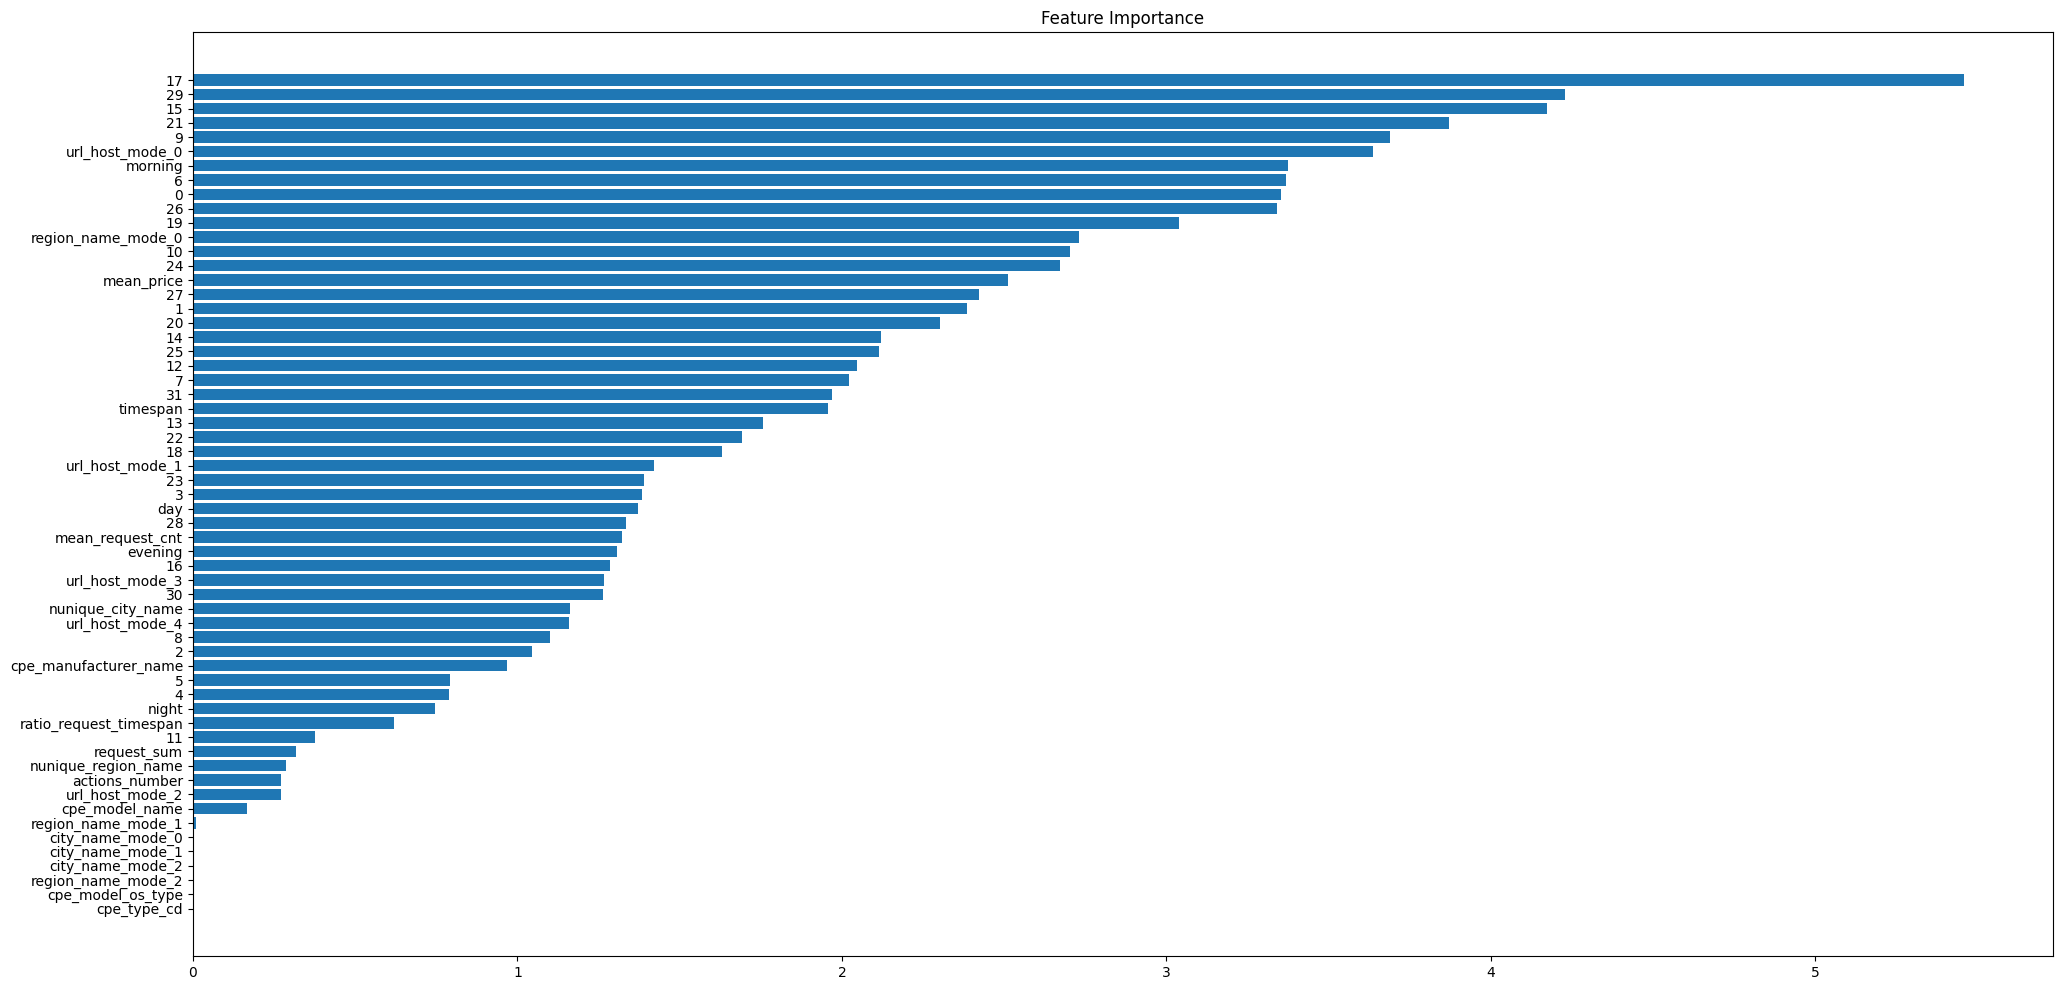

In [30]:
feature_importance = model_age.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(24, 12))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

#### is_ male classification training

In [31]:
from catboost import Pool
from catboost import CatBoostClassifier
from catboost.utils import get_gpu_device_count

from sklearn.model_selection import train_test_split

from catboost_modules.metrics import GENDER_METRIC

In [32]:
df_sex = userfe.df[userfe.df["is_male"].notna()]

In [33]:
X_train, X_test, y_train, y_test = train_test_split(df_sex.drop(["age", "is_male", "user_id"], axis=1), df_sex["is_male"], test_size=0.2, random_state=42)

train_dataset = Pool(X_train, y_train, cat_features=np.where(df_sex.drop(["age", "is_male", "user_id"], axis=1).dtypes == object)[0])
test_dataset = Pool(X_test, y_test, cat_features=np.where(df_sex.drop(["age", "is_male", "user_id"], axis=1).dtypes == object)[0])

In [34]:
params = {"loss_function": "Logloss",
          "eval_metric": "NormalizedGini",
          "verbose": 100,
          "iterations": 4000,
          "random_state": 42,
          "task_type": "GPU" if get_gpu_device_count() else "CPU",
          "early_stopping_rounds": 100,
          "use_best_model": True,
         }

model_sex = CatBoostClassifier(**params)

In [35]:
model_sex.fit(train_dataset, eval_set=test_dataset)

Learning rate set to 0.03519


Default metric period is 5 because NormalizedGini is/are not implemented for GPU
Metric NormalizedGini is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.3378386	best: 0.3378386 (0)	total: 246ms	remaining: 16m 22s
100:	test: 0.5787618	best: 0.5787618 (100)	total: 7.91s	remaining: 5m 5s
200:	test: 0.6226789	best: 0.6226789 (200)	total: 15.5s	remaining: 4m 53s
300:	test: 0.6416653	best: 0.6416653 (300)	total: 23s	remaining: 4m 42s
400:	test: 0.6511997	best: 0.6520119 (394)	total: 30.7s	remaining: 4m 35s
500:	test: 0.6598101	best: 0.6598984 (499)	total: 38.2s	remaining: 4m 26s
600:	test: 0.6628352	best: 0.6633944 (539)	total: 45.7s	remaining: 4m 18s
700:	test: 0.6644537	best: 0.6647304 (615)	total: 53.3s	remaining: 4m 10s
800:	test: 0.6700508	best: 0.6702097 (799)	total: 1m	remaining: 4m 3s
bestTest = 0.670209698
bestIteration = 799
Shrink model to first 800 iterations.


In [36]:
GENDER_METRIC(model_sex.predict_proba(X_test), y_test)

{'Gender GINI': -0.6702096980183744}

Text(0.5, 1.0, 'Feature Importance')

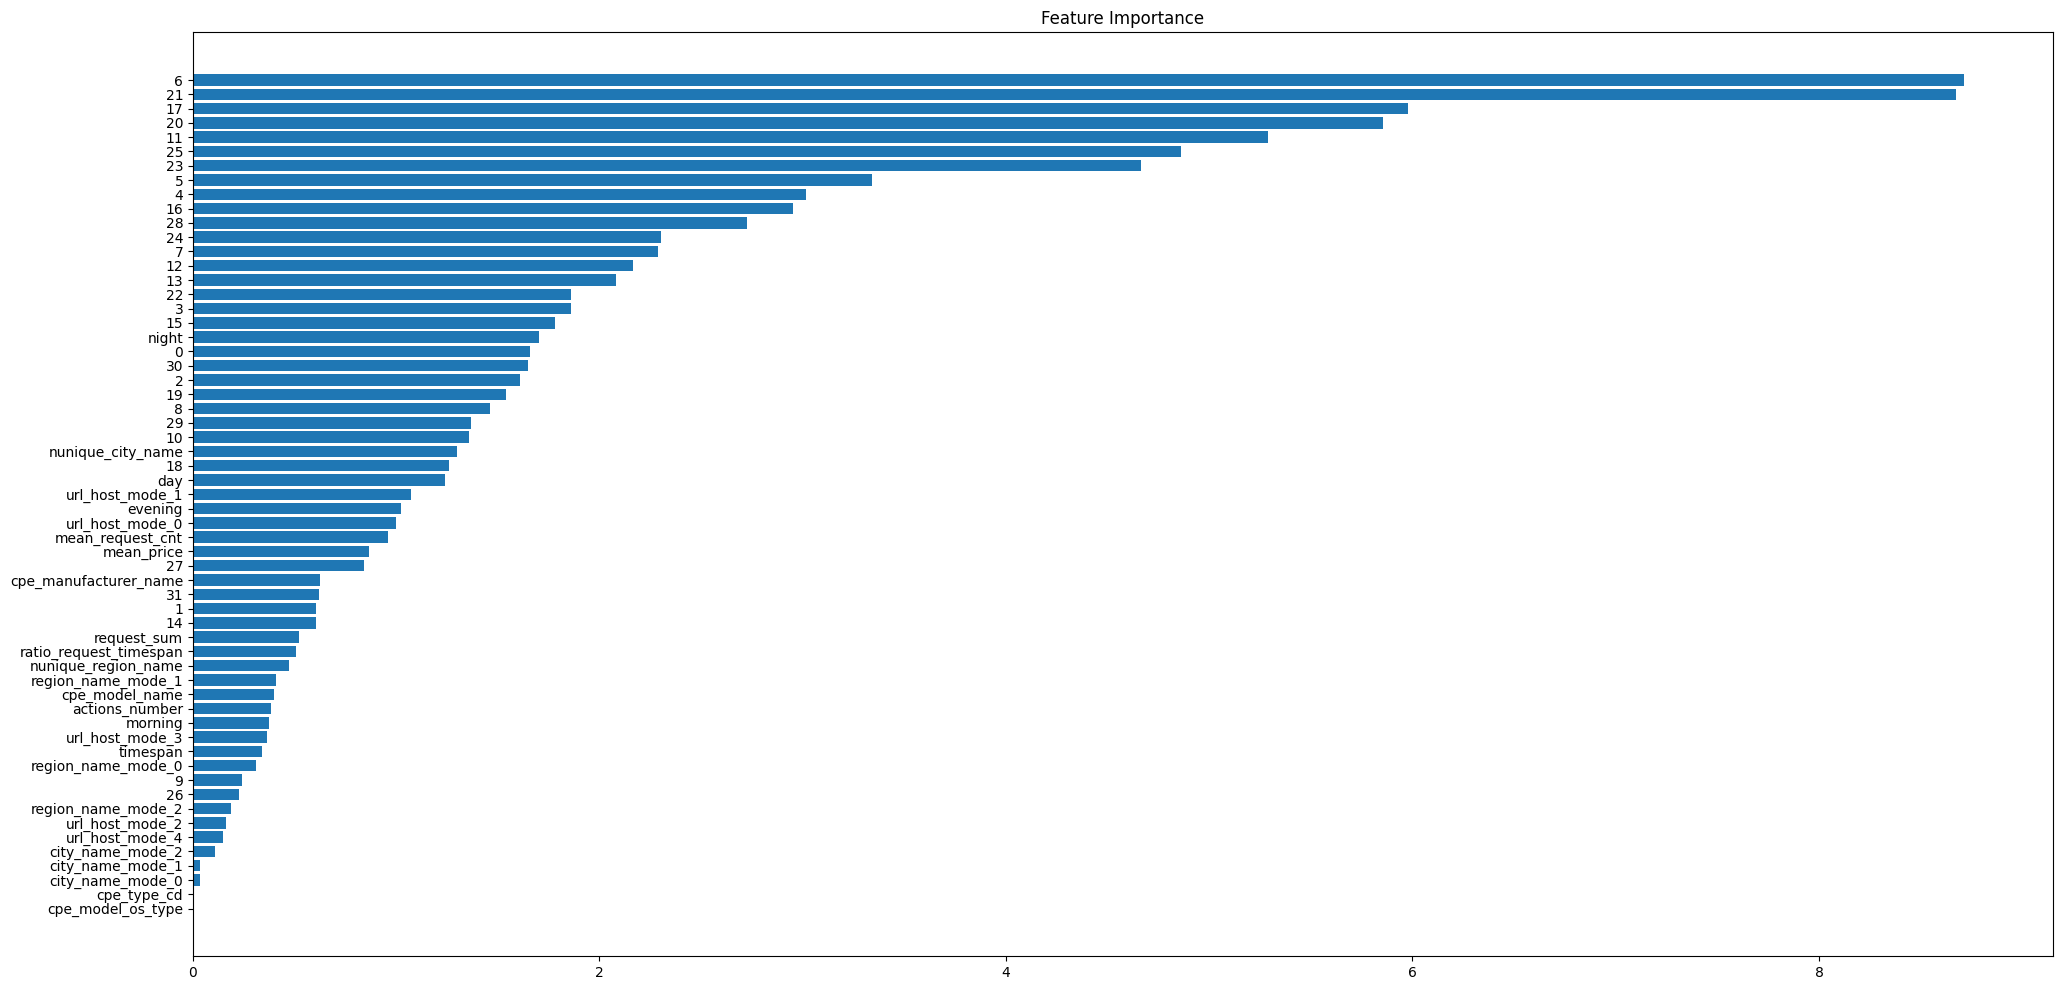

In [37]:
feature_importance = model_sex.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(24, 12))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

#### Age regression training

In [24]:
from catboost import Pool
from catboost import CatBoostRegressor
from catboost.utils import get_gpu_device_count

from sklearn.model_selection import train_test_split

from catboost_modules.metrics import AGE_METRIC_REGRESSION

In [25]:
df_age = userfe.df[userfe.df["age"].notna()]

In [26]:
X_train, X_test, y_train, y_test = train_test_split(df_age.drop(["age", "is_male", "user_id"], axis=1), df_age["age"], test_size=0.2, random_state=42)

train_dataset = Pool(X_train, y_train, cat_features=np.where(df_age.drop(["age", "is_male", "user_id"], axis=1).dtypes == object)[0])
test_dataset = Pool(X_test, y_test, cat_features=np.where(df_age.drop(["age", "is_male", "user_id"], axis=1).dtypes == object)[0])

In [27]:
params = {"loss_function": "RMSE",
          "eval_metric": "MAE",
          "verbose": 100,
          "iterations": 4000,
          "random_state": 42,
          "task_type": "GPU" if get_gpu_device_count() else "CPU",
          "early_stopping_rounds": 50,
          "use_best_model": True,
         }

model_age = CatBoostRegressor(**params)

In [28]:
model_age.fit(train_dataset, eval_set=test_dataset)

In [ ]:
AGE_METRIC_REGRESSION(model_age.predict(X_test), y_test)